In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [3]:
def sample_reward(distr, params):
    if distr == 'uniform':
        return np.random.uniform(params[0], params[1])
    elif distr == 'normal':
        return np.random.normal(params[0], np.sqrt(params[1]))
    else:
        print("The reward function is not defined. Exiting!")
        sys.exit()

**The Bandits Algorithm**

In [4]:
class Bandits:
    # for the sake of simplicity the rewards are drawn from Uniforms and normals
    def __init__(self):
        #fixed set of arms 
        self.reward_details = {'N_arms': 5,
                              'distr': ['uniform', 'uniform', 'uniform', 'normal', 'normal'],
                              'params': [(0., 1.), (-1., 2), (1, 2), (0, 1), (1.5, 2)],
                             }
        self.Q_t = np.zeros(5)
        self.N_t = np.zeros(5)
        self.alpha = 1e-3
        self.eps = 0.01
        self.c = 0.10
        self.avg_reward = [0]
        # self.avg_reward_ucb = [0]
    
    def get_optimal_reward(self):
        max_reward = -np.inf
        for i in range(self.reward_details['N_arms']):
            if self.reward_details['distr'][i] == 'uniform':
                r = (self.reward_details['params'][i][1] - self.reward_details['params'][i][0])/2.0
            elif self.reward_details['distr'][i] == 'normal':
                r = self.reward_details['params'][i][0]
            else:
                print("The reward function is not defined. Exiting!")
                sys.exit()
            if r > max_reward:
                max_reward = r
        return max_reward
    
    def plot_Bandits_learning(self):
        # plots the action
        plt.bar(np.arange(self.reward_details['N_arms']), self.N_t)
        plt.xlabel('Action')
        plt.ylabel('# selections')
        plt.title('Action selection Distribution')
        # plt.close()

        # plots the average reward at every step
        plt.figure()
        #optimal reward - in this case
        plt.plot(np.log(np.arange(len(self.avg_reward))+1), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        plt.plot(np.log(np.arange(len(self.avg_reward))+1), self.avg_reward)
        # plt.plot(np.arange(len(self.avg_reward)), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        # plt.plot(np.arange(len(self.avg_reward)), self.avg_reward)
        plt.xlabel('Number of Steps (log scale)')
        plt.ylabel('Average Reward')
        plt.title('Learning Curve for Bandits Agent')
        plt.legend()   
        # plt.close()
    
    def plot_Bandits_learning_compare(self, all_curves, cs):
        # plots the average reward at every step
        plt.figure()
        #optimal reward - in this case
        plt.plot(np.log(np.arange(len(self.avg_reward))+1), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        for i in range(len(cs)):
            plt.plot(np.log(np.arange(len(all_curves[i]))+1), all_curves[i], label='c='+str(cs[i]))
        # plt.plot(np.arange(len(self.avg_reward)), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        # plt.plot(np.arange(len(self.avg_reward)), self.avg_reward)
        plt.xlabel('Number of Steps (log scale)')
        plt.ylabel('Average Reward')
        plt.title('Learning Curve for Bandits Agent')
        plt.legend()   
        # plt.close()

    def take_action_UCB(self):
        #N_t[a] : is the number of times action a was selected
        #so np.sum takes the sum over all the actions  (thus total time)
        ucb_f = self.Q_t + self.c * np.sqrt(np.log(1 + np.sum(self.N_t))/(self.N_t + 1e-11))
        a_t = np.argmax(ucb_f)
        self.N_t[a_t] += 1
        return a_t 
    
    def take_action_epsilon_greedy(self):
        if np.random.rand() <= self.eps:
            a_t = np.random.choice(self.reward_details['N_arms'])
        else: 
            a_t = np.argmax(self.Q_t)  # select the best action
        
        self.N_t[a_t] += 1
        return a_t
    
    def observe_reward(self, a_t):
        # return the estimate of r_t
        r_t = sample_reward(self.reward_details['distr'][a_t], self.reward_details['params'][a_t])
        return r_t
        
    def update_Q(self, a_t, r_t):
        #get the estimate for Q_t+1
        self.Q_t[a_t] = self.Q_t[a_t] + (r_t - self.Q_t[a_t])/self.N_t[a_t]
    
    def learn(self, ep_greedy=True, N_steps=100_000):
        for i in range(N_steps):
            if ep_greedy == True:
                a_t = self.take_action_epsilon_greedy()
            else:  #ucb action selection
                a_t = self.take_action_UCB()
                
            r_t = self.observe_reward(a_t)
            self.update_Q(a_t, r_t)
            # keep track of the average reward
            temp_avg_reward = self.avg_reward[-1] + (r_t - self.avg_reward[-1])/(i+1)
            self.avg_reward.append(temp_avg_reward)

    def compare_ucb(self, cs=[0.01, 0.10, 1.0, 10.0], N_steps = 100_000):
        all_curves = []
        for c in cs:
            self.c = c
            temp_curves = []
            for i in range(N_steps):
                a_t = self.take_action_UCB()
                r_t = self.observe_reward(a_t)
                self.update_Q(a_t, r_t)
                temp_avg_reward = self.avg_reward[-1] + (r_t - self.avg_reward[-1])/(i+1)
                temp_curves.append(temp_avg_reward)

            all_curves.append(temp_curves)
        return all_curves, cs
            
    

**Bandits Action Selection - UCB**

In [9]:
bandits_obj = Bandits()
bandits_obj.learn(ep_greedy=False)

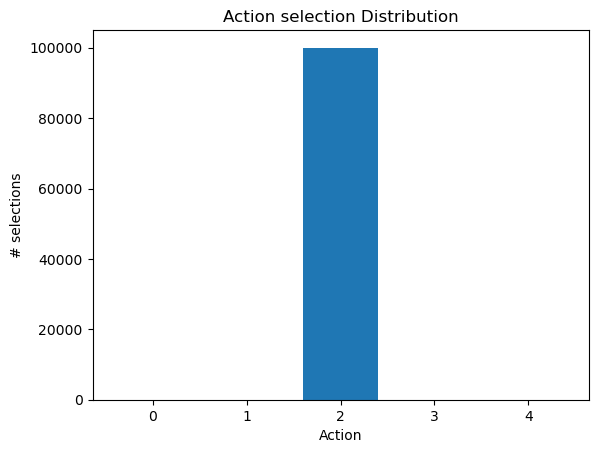

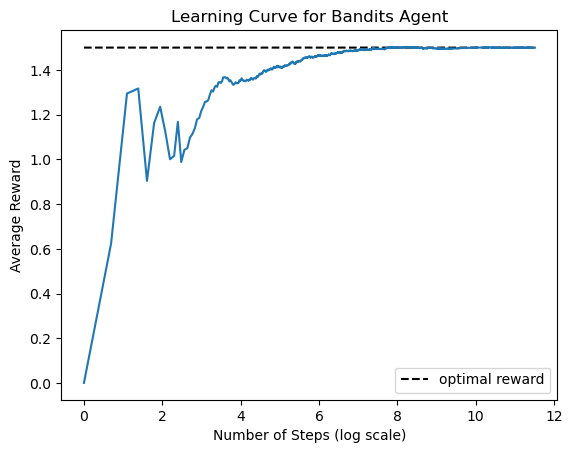

In [10]:
bandits_obj.plot_Bandits_learning()

In [16]:
#Converges to exactly 1.5

**Comparing UCB hyperparameter**

In [17]:
all_curves, cs = bandits_obj.compare_ucb(cs=[0.01, 1.0])

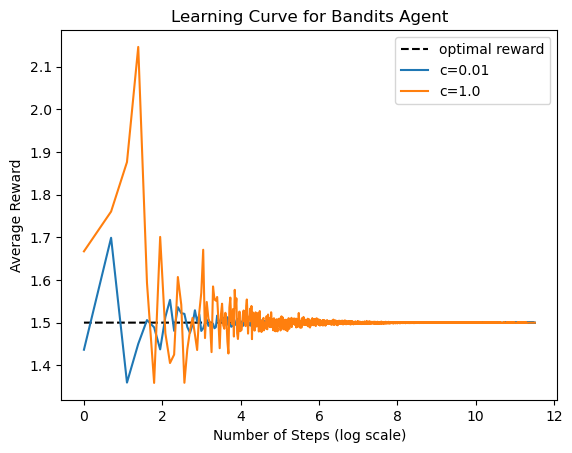

In [18]:
bandits_obj.plot_Bandits_learning_compare(all_curves, cs)

high c:- means you initially give a lot of weight to expoloration
Adv:- You never have noisy estimates... converges in such disciplined way
Disadv:- You take time in converging to the value

Low c:-Low weightage to exploration 
Adv :- Oscillates about the best
Disadv:- Has a lot of noise, sample random arms having any or nearly same reward, takes time in understanding which arm is the best is the best



---

## 🔍 Effect of Varying `c` in UCB Algorithm

| Setting      | Description                               | Advantages                                                           | Disadvantages                                                                                                     |
| ------------ | ----------------------------------------- | -------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **High `c`** | High emphasis on exploration              | ✅ You never have noisy estimates<br>✅ Converges in a disciplined way | ❌ Takes longer to converge to the optimal action                                                                  |
| **Low `c`**  | Low emphasis on exploration (more greedy) | ✅ Quickly oscillates near the best arm                               | ❌ High variance in updates<br>❌ Often samples suboptimal arms<br>❌ Struggles to confidently identify the best arm |

---

### 💡 Summary

* `c` controls the **exploration-exploitation trade-off** in UCB.
* Use **higher `c`** when you're unsure and want reliable estimates.
* Use **lower `c`** when the environment is stable and fast convergence is preferred, but at the cost of noisy learning.

---

